# Plate Cutting - An Optimization Approach

The purpose of this notebook is to analyze data from a plate cutter in a manufacturing environment and find ways to improve efficiency. It documents the full process of loading and cleaning raw CSV files to analyzing each column. We'll process and visualize the data to identify trends and inefficiencies. The goal is to turn raw machine logs into meaningful insights to help to optimize the cutting process.

Please run notebook sequentially.

## Pre-processing

We will check that all csv's have the same column names, and then we will concatenate all of the csv's into a single file.

In [46]:
# Files are located in data/landing folder. We must ensure all files have the same column names or we wont be able to merge them.

import pandas as pd
import os

# Variables
landing_folder = "../data/landing/files"
columns = ['ProgramName', 'Start', 'End', 'Cancelled', 'TotalTime', 'BreakingTime', 'NumberBreaks', 'Process1Time',
           'Process1Length', 'Process1Starts', 'Process2Time', 'Process2Length', 'Process2Starts', 'Process3Time', 
           'Process3Length', 'Process3Starts', 'Process4Time', 'Process4Length', 'Process4Starts', 'RapidTime', 'RapidLength', 
           'RapidStarts']


# Function to load a file into a pandas dataframe
def load_file(*args, **kwargs):
    try:
        return pd.read_csv(*args, **kwargs)
    except Exception as e:
        print(f"Error loading file: {args[0]}")
        print(e)


# Function to read a file and compare name of columns with list of columns we expect
def check_column_names(file, columns):
    df = load_file(file, delimiter=';')

    if not all([col in df.columns for col in columns]):
        print(f"Columns in {file} do not match expected columns")
        print(f"Missing columns: {set(columns) - set(df.columns)}")
        print(f"Extra columns: {set(df.columns) - set(columns)}\n\n")


# check if all files have correct columns
for file in os.listdir(landing_folder):
    check_column_names(f"{landing_folder}/{file}", columns)

In [47]:
# Variables
concatenated_file_path = "../data/landing/concat_file/full_file.csv"


# Updated merge function using pd.concat()
def merge_files(landing_folder):
    all_files = [os.path.join(landing_folder, file) for file in os.listdir(landing_folder) if file.endswith(".csv")]
    
    df_list = [load_file(file, delimiter=";") for file in all_files]
    df = pd.concat(df_list, ignore_index=True)
    
    return df


def create_folder(folder):
    os.makedirs(folder, exist_ok=True)


def save_file(df, file):
    create_folder(os.path.dirname(file))
    df.to_csv(file, index=False, sep=";")


df_full_plates = merge_files(landing_folder)
save_file(df_full_plates, concatenated_file_path)
print(f"File saved: {concatenated_file_path}")


File saved: ../data/landing/concat_file/full_file.csv


In [ ]:
# Variables
cleaned_file_path = "../data/transform/clean/cleaned_file.csv"
expected_cols = ["ProgramName", "Start", "End", "Cancelled", "TotalTime", "BreakingTime",
    "NumberBreaks", "Process1Time", "Process1Length", "Process1Starts", "RapidTime",
    "RapidLength", "RapidStarts"]# These are the columns we will use for analysis as per PDF

cols_of_interest = ['ProgramName', 'BreakingTime', 'Process1Time', 'Process1Length', 'RapidLength']

col_id_name = 'ProgramName'

# True if any value is zero, drops columns with all zeros since they wpuld not have at least was TRUE returned in the filter df
def drop_zero_columns(df):
    return df.loc[:, (df != 0).any(axis=0)]


# Check if 'ProgramName' contains only numeric values
def clean_program_name(df):
    df = df[df['ProgramName'].astype(str).str.isnumeric()] # returns true if all characters in the string are numeric
    df['ProgramName'] = df[col_id_name].astype(int) # Removes leading zeros
    return df


# Remove duplicate ProgramName rows, keep the first occurrence
def remove_duplicates(df, subset):
    return df.drop_duplicates(subset=subset, keep='first')


def remove_cancelled_processes(df):
    return df[df["Cancelled"] != True] # for remove rows where 'Cancelled' is True


# Remove rows where key columns contain zero
def remove_invalid_time_entries(df, key_columns):
    return df[(df[key_columns]!= 0).all(axis=1)]


# Check if remaining columns match the desired list
def validate_columns(df, expected_columns):
    remaining_columns = df.columns.to_list()
    if remaining_columns != expected_columns:
        missing_columns = expected_columns - remaining_columns
        extra_columns = remaining_columns - expected_columns
        print(f"Warning: Column mismatch detected!\nMissing: {missing_columns}\nExtra: {extra_columns}")
    else:
        print("Column validation successful. All required columns are present.")


# Apply transformations
df_full_plates = drop_zero_columns(df_full_plates)
df_full_plates = clean_program_name(df_full_plates)
df_full_plates = remove_duplicates(df_full_plates, ['ProgramName'])
df_full_plates = remove_cancelled_processes(df_full_plates)
df_full_plates = remove_invalid_time_entries(df_full_plates, cols_of_interest)


validate_columns(df_full_plates, expected_cols)


save_file(df_full_plates, cleaned_file_path)
print(f"Cleaned file saved: {cleaned_file_path}")

Column validation successful. All required columns are present.
Cleaned file saved: ../data/transform/clean/cleaned_file.csv


C:\Users\emili\AppData\Local\Temp\ipykernel_19380\761726100.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ProgramName'] = df[col_id_name].astype(int)


## Analysis
### Post-processing EDA

After the above code has executed, we can expect the CSVs to be checked against the each other to confirm they all have the same columns. We then concatenate into a single file as save to landing folder.

After doing preliminary cleaning, we save the table on transform clean. At this point it will be useful to check for shape, distribution and general stats of the data.

Top Records:
   ProgramName               Start                 End  Cancelled  TotalTime  \
1         4392 2025-06-21 03:04:26 2025-06-21 03:26:32      False       1325   
2         3887 2025-06-21 03:32:07 2025-06-21 04:07:38      False       2126   
3         4472 2025-06-21 04:09:00 2025-06-21 04:21:51      False        766   
6         4402 2025-06-21 05:43:52 2025-06-21 05:49:27      False        333   
7         4334 2025-06-21 06:12:14 2025-06-21 06:43:59      False       1900   

   BreakingTime  NumberBreaks  Process1Time  Process1Length  Process1Starts  \
1            23             4           324    15738.717773              69   
2           107             7           563    28534.375000              11   
3             6             1           409    19713.322266              12   
6             2             2           183     4500.993164               4   
7            18             2           460    27593.513672              78   

   RapidTime  RapidLength  Rapi

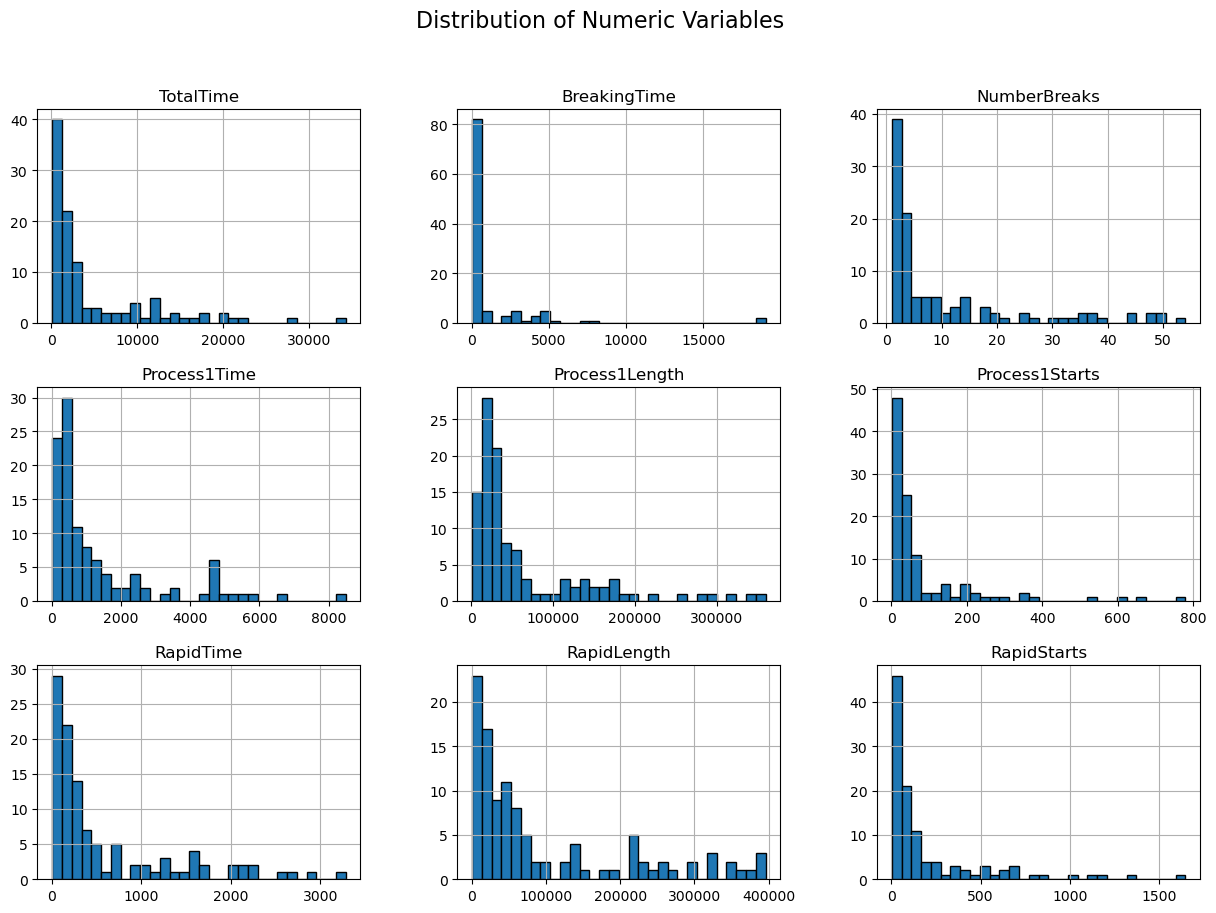

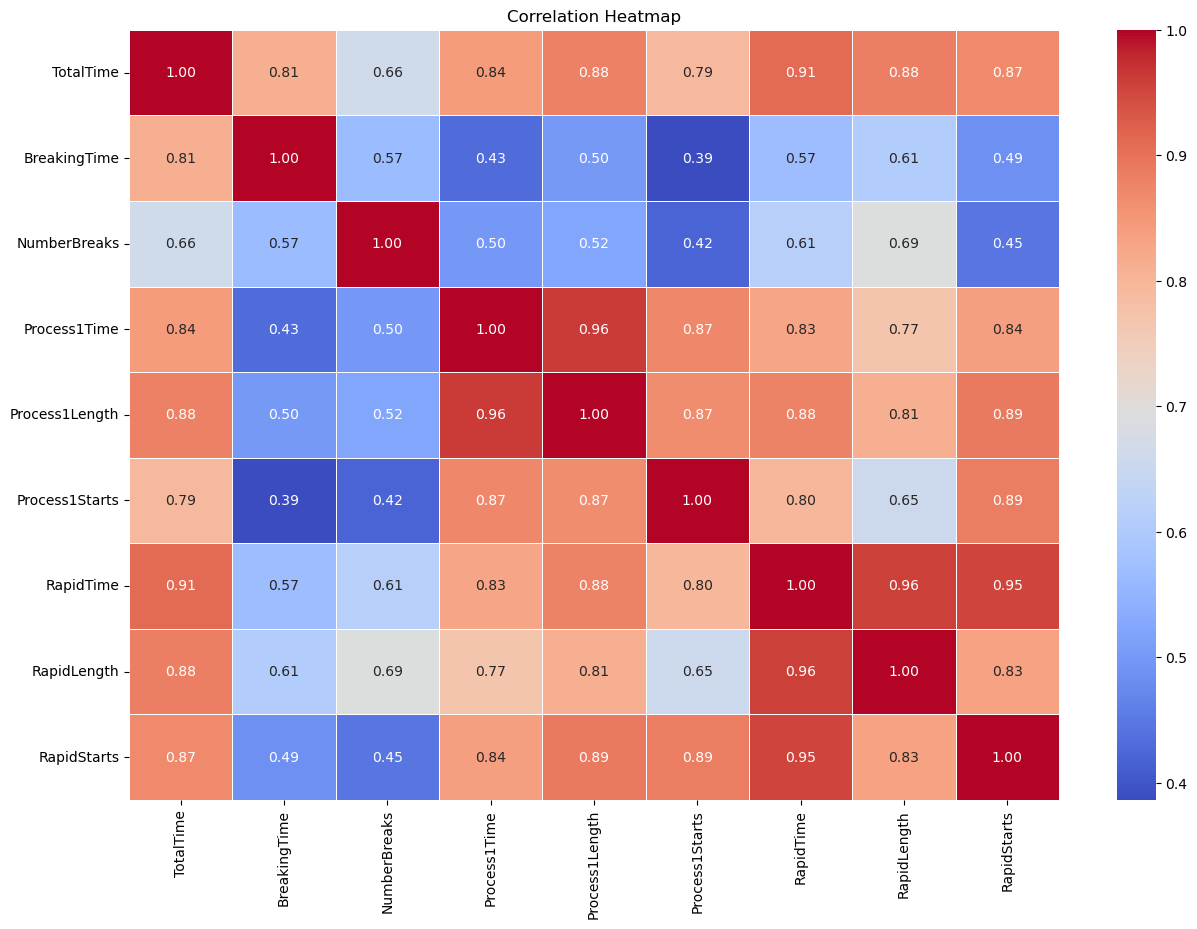

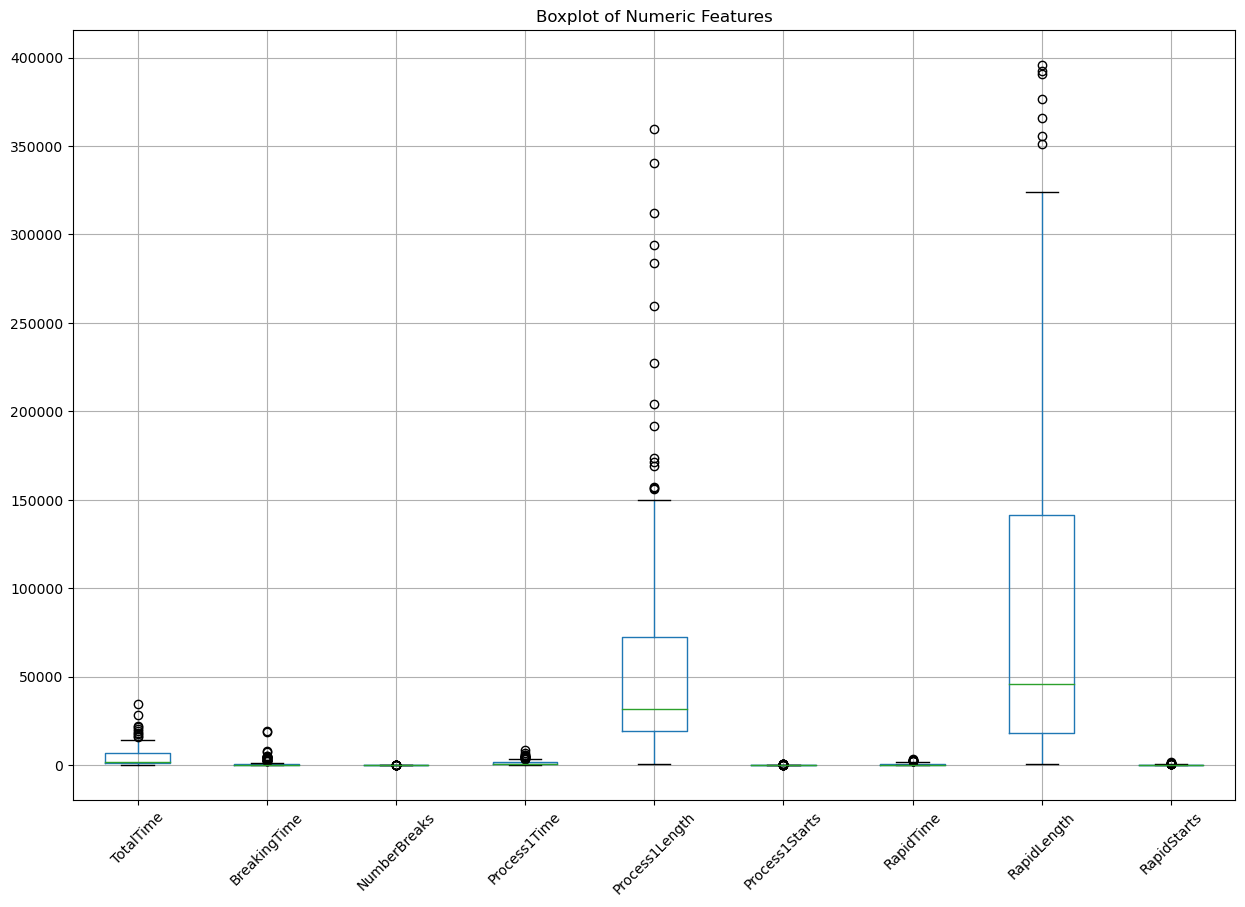

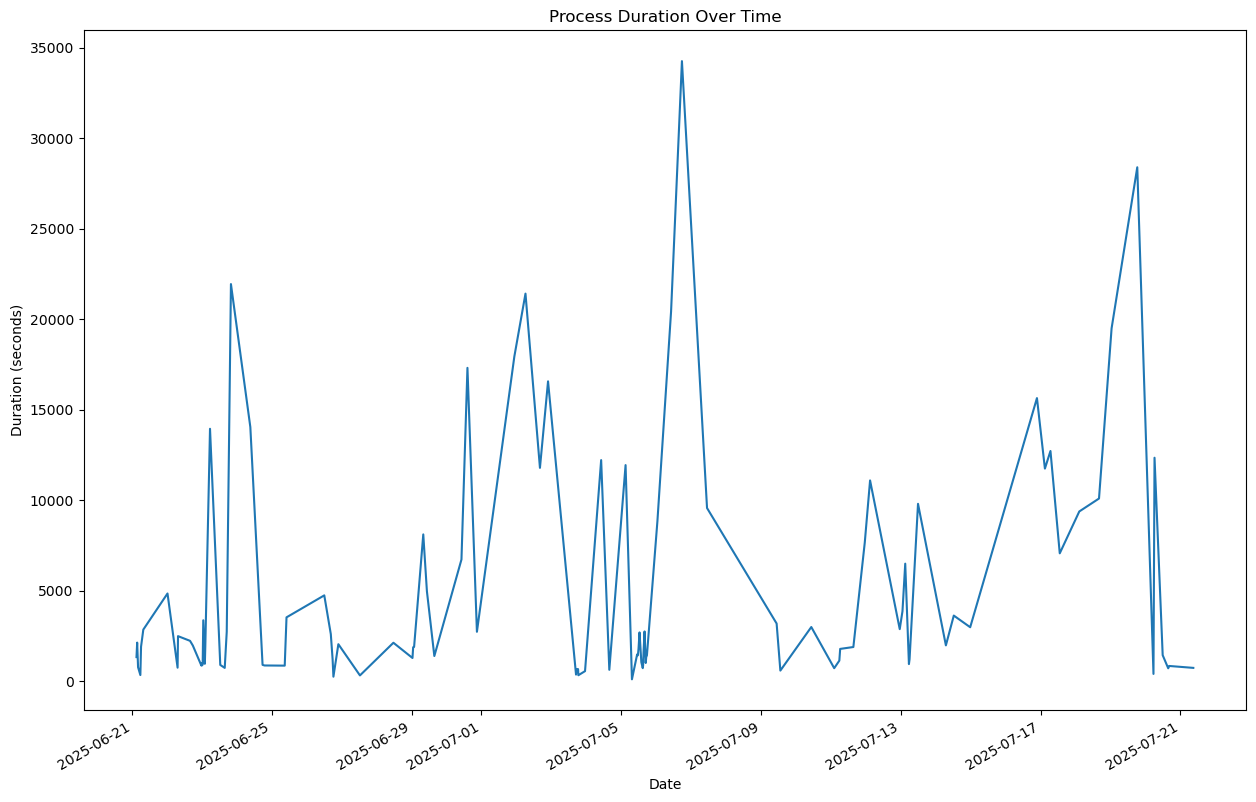

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Variables
datetime_columns = ['Start', 'End']

def convert_datetime(df, datetime_columns): # Function to convert columns to datetime
    df_ = df.copy()
    for col in datetime_columns:
        df_[col] = pd.to_datetime(df_[col])
    return df_

def apply_log_transformation(df, columns):
    df_log = df.copy()
    df_log[columns] = df_log[columns].apply(lambda x: np.log1p(x))
    return df_log

# Function for EDA
def perform_eda(df, figsize=(15, 10), apply_transformation=False):

    df_ = df.copy() # to avoid modifying the original dataframe
    numeric_columns = df_.select_dtypes(include=['int64', 'float64']).columns
    
    if apply_transformation:
        df_ = apply_log_transformation(df_, numeric_columns)
        
    print("Top Records:")
    print(df_.head())
    
    print("\nSummary Statistics:")
    print(df_.describe())
    
    print("\nColumn Data Types:")
    print(df_.dtypes)
    
    print("\nMissing Values:")
    print(df_.isnull().sum())
    
    print("\nCategorical Column Classes:") #There seem to be no categorical columns but this function would still be ran in a real world scenario
    
    categorical_columns = df_.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        print(f"{col}: {df_[col].unique()}")

    df_[numeric_columns].hist(figsize=figsize, bins=30, edgecolor='black') # Histograms for easier visualization of distribution
    plt.suptitle("Distribution of Numeric Variables", fontsize=16)
    plt.show()
    
    plt.figure(figsize=figsize)
    sns.heatmap(df_[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)  # Correlation Heatmap to identify possible multicollinearity
    plt.title("Correlation Heatmap")
    plt.show()
   
    plt.figure(figsize=figsize) # boxplot for detecting outliers
    df_[numeric_columns].boxplot(rot=45)
    plt.title("Boxplot of Numeric Features")
    plt.show()
    
    # Time-based Analysis - Process Duration Over Time. If transformation is applied, the below won't execute as the columns are converted to log
    if not apply_transformation:
        time_df_ = df_.copy()
        time_df_.set_index(datetime_columns[0], inplace=True)
        plt.figure(figsize=figsize)
        time_df_['TotalTime'].plot()
        plt.title("Process Duration Over Time")
        plt.xlabel("Date")
        plt.ylabel("Duration (seconds)")
        plt.show()
    
    # Count plot for categorical variables, even if there are none in our specific case
    for col in categorical_columns:
        plt.figure(figsize=figsize)
        sns.countplot(x=df_[col], data=df_, palette='viridis')
        plt.title(f"Count of {col}")                                                                                                                               
        plt.xticks(rotation=45)
        plt.show()


# Perform EDA
df_full_plates = convert_datetime(df_full_plates, datetime_columns)                                                                        
perform_eda(df_full_plates, apply_transformation=False)

Note: I first ran the EDA with original values but immediately knew applying a log transformation would be yield better isnights. For this reason, I have added a transformation parameter in the above function. The timeseries won't print as there is no advantage in plotting log tranformed timeseries.

Top Records:
   ProgramName               Start                 End  Cancelled  TotalTime  \
1         4392 2025-06-21 03:04:26 2025-06-21 03:26:32      False   7.189922   
2         3887 2025-06-21 03:32:07 2025-06-21 04:07:38      False   7.662468   
3         4472 2025-06-21 04:09:00 2025-06-21 04:21:51      False   6.642487   
6         4402 2025-06-21 05:43:52 2025-06-21 05:49:27      False   5.811141   
7         4334 2025-06-21 06:12:14 2025-06-21 06:43:59      False   7.550135   

   BreakingTime  NumberBreaks  Process1Time  Process1Length  Process1Starts  \
1      3.178054      1.609438      5.783825        9.663943        4.248495   
2      4.682131      2.079442      6.335054       10.258900        2.484907   
3      1.945910      0.693147      6.016157        9.889101        2.564949   
6      1.098612      1.098612      5.214936        8.412276        1.609438   
7      2.944439      1.098612      6.133398       10.225372        4.369448   

   RapidTime  RapidLength  Rapi

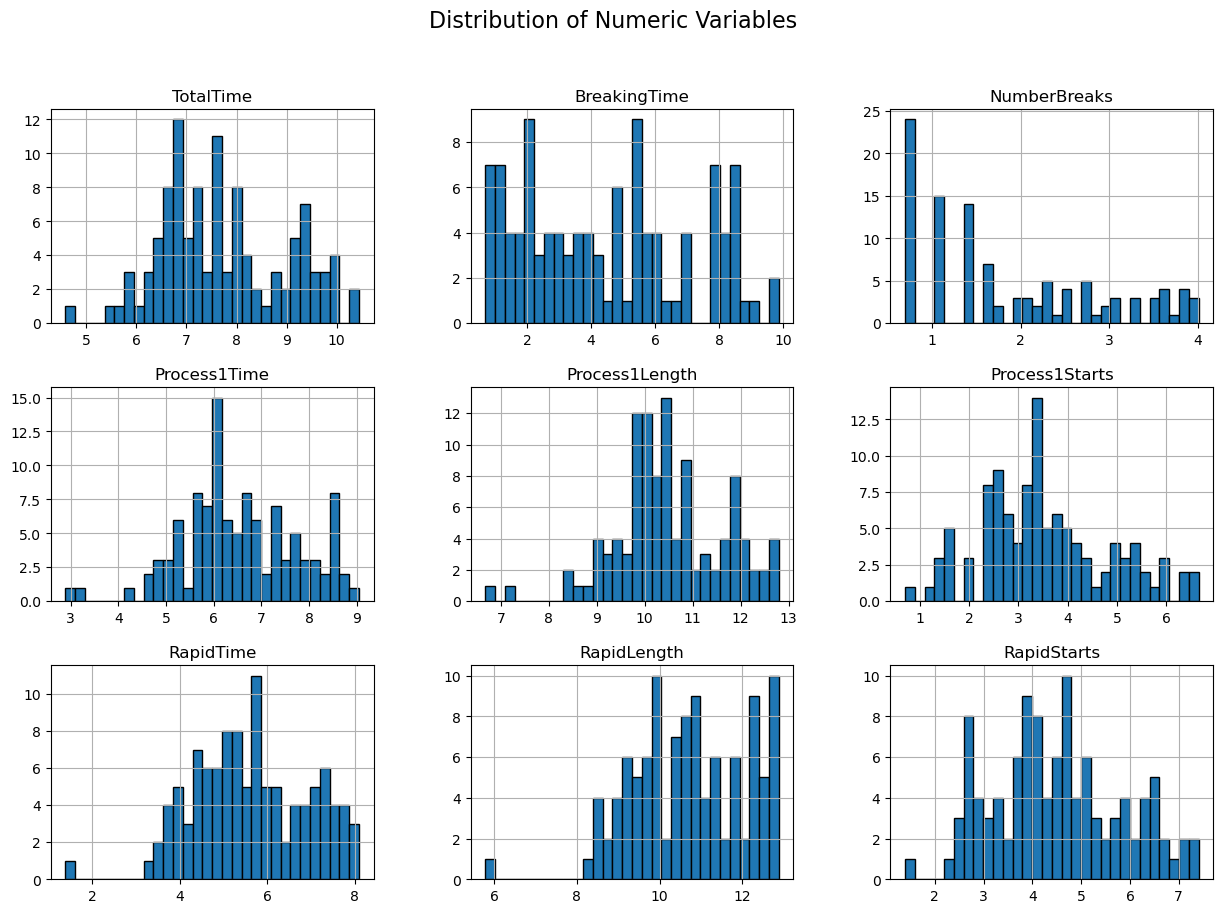

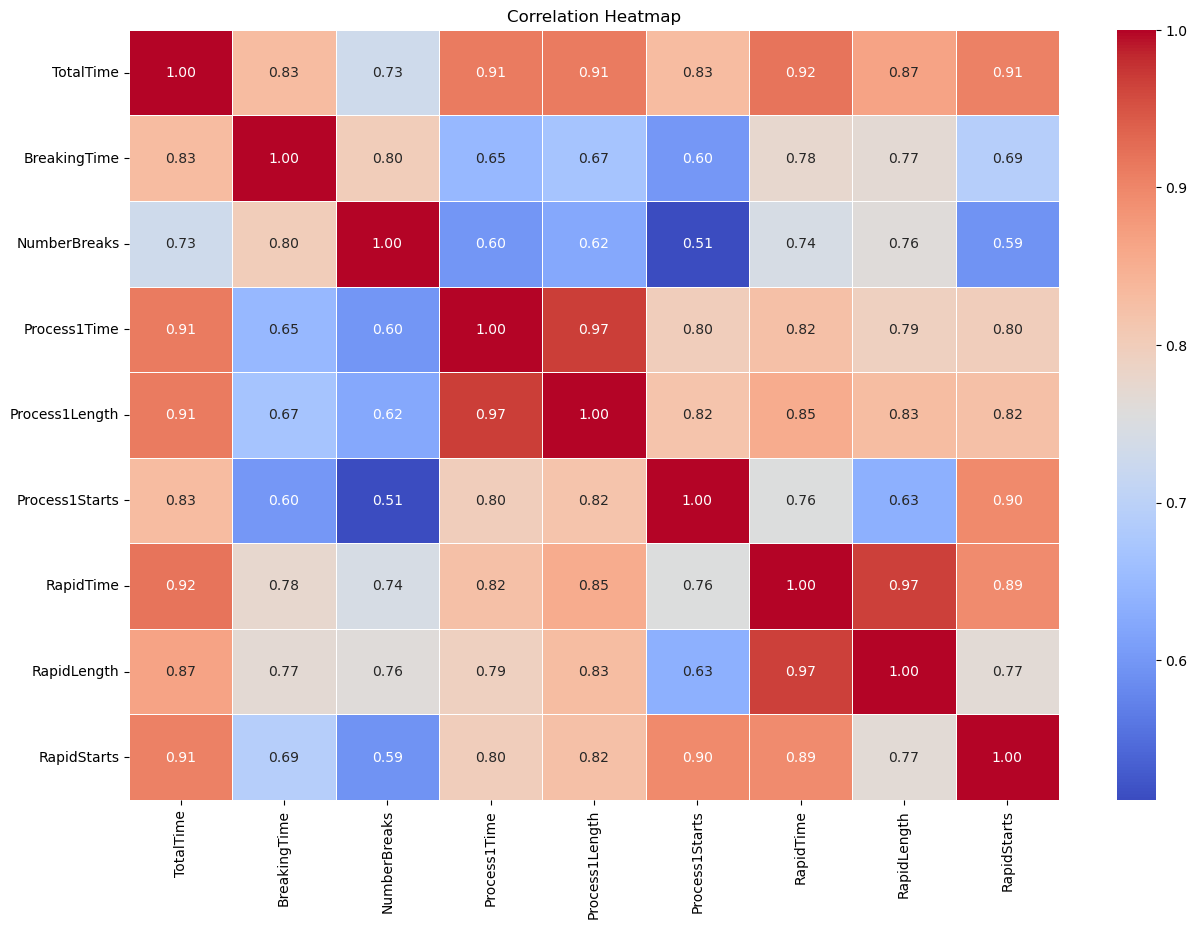

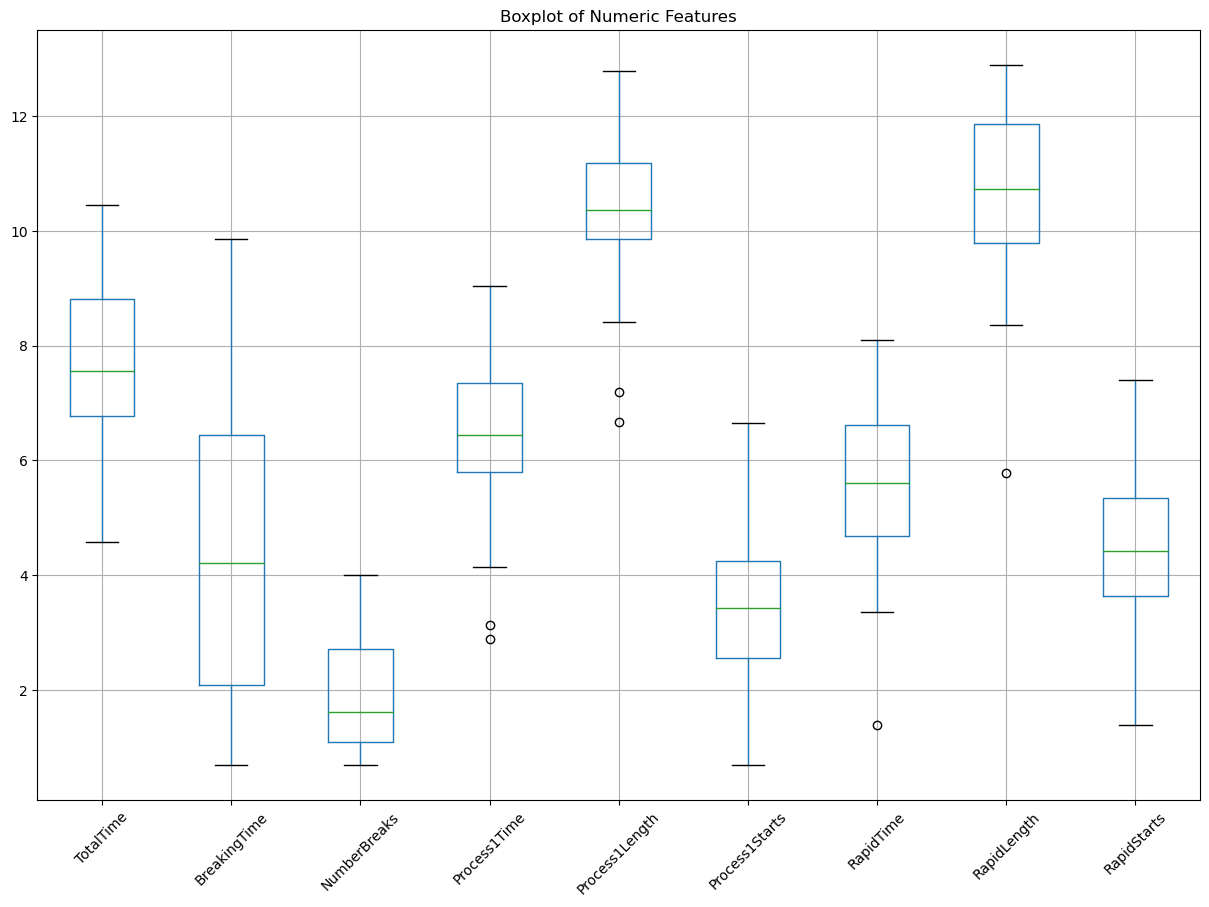

In [50]:
perform_eda(df_full_plates, apply_transformation=True)

- Nnumerical features TotalTime, Process1Time, and RapidTime, show a right-skewed distribution, meaning some programs take significantly longer than others.

- NumberBreaks has a sharp drop-off after 2-3 breaks, indicating most programs have minimal interruptions.

- TotalTime strongly correlates with Process1Time (0.91), RapidTime (0.92), and RapidStarts (0.91)

- BreakingTime (0.83 correlation with TotalTime) shows that parts removal significantly impact efficiency.

### Feature Importance

This section explores the significance of various features in the dataset to identify key drivers of efficiency.

Mean Squared Error: 0.03471265722116656
R2 Score: 0.9722365537626639
Model Coefficients: [ 0.13699301  0.01665456  0.52875763 -0.13168414 -0.0304217  -0.06728851
  0.10469407  0.36895028]
Model Intercept: 2.7222764898703993


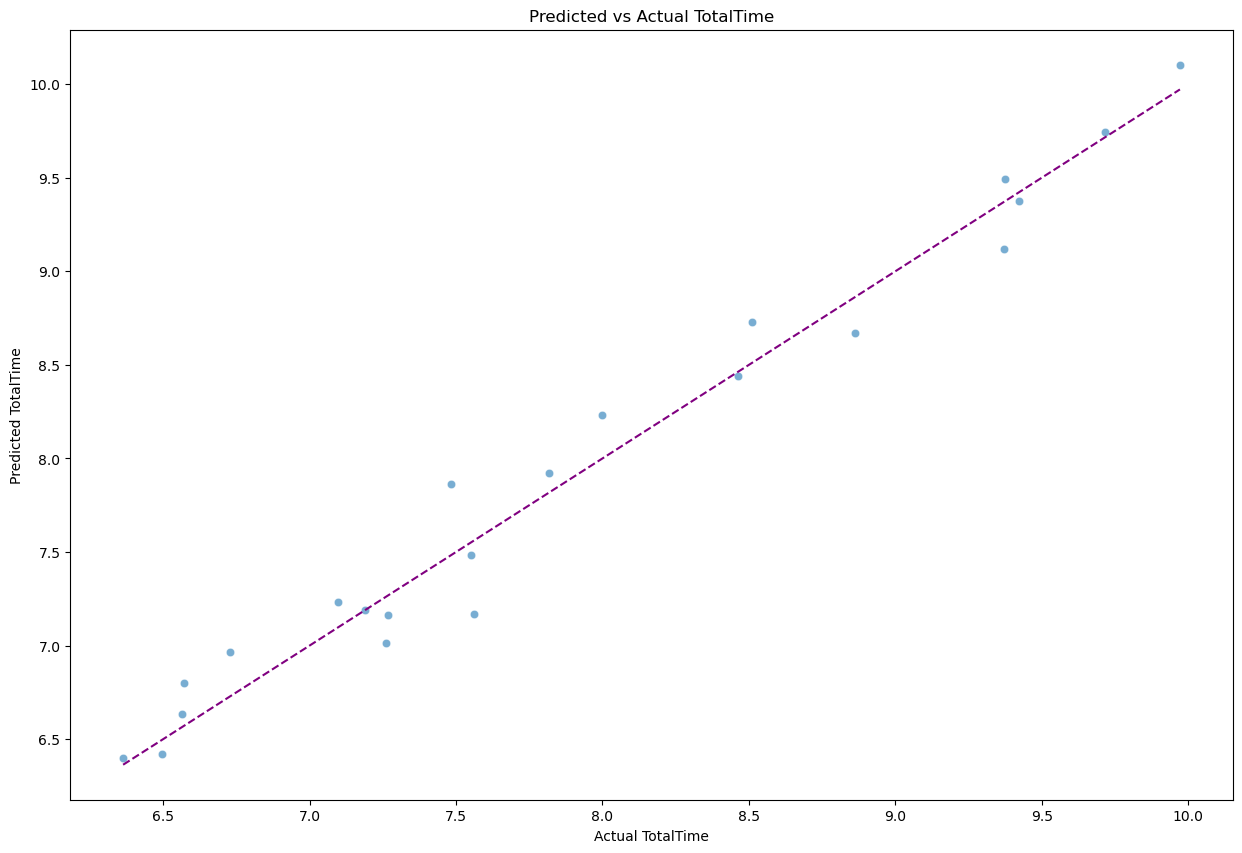

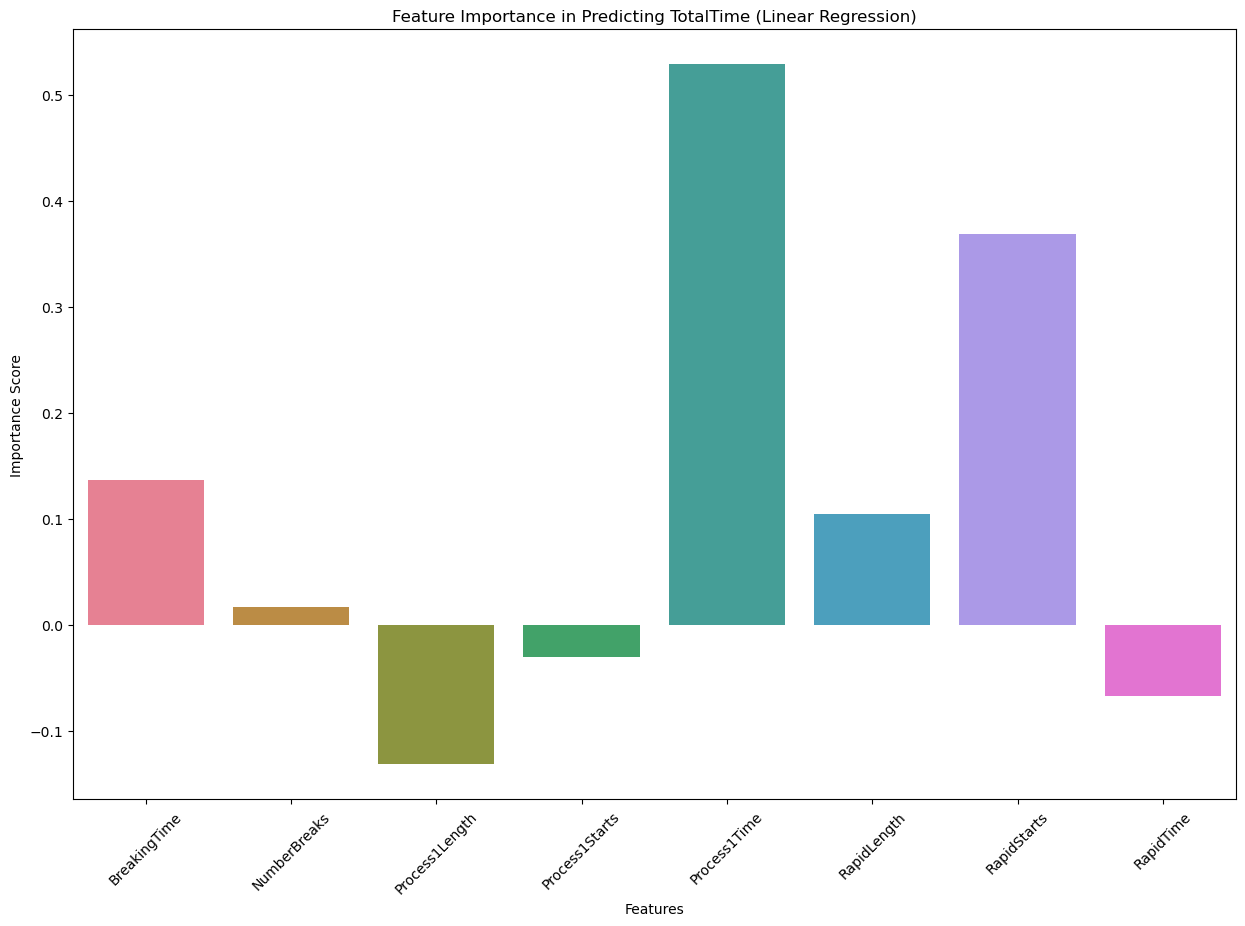

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Variables
df_numerical_cols = df_full_plates.select_dtypes(include=['int64', 'float64'])
transformed_log_file_path = "../data/transform/log/log_file.csv"
log_transform_cols = df_numerical_cols.columns.tolist()
target_column = 'TotalTime'


df_full_plates_log = apply_log_transformation(df_numerical_cols, log_transform_cols)


save_file(df_full_plates_log, transformed_log_file_path)


def plot_feature_importance(feature_importance, title, figsize=(15, 10)):
    feature_importance = feature_importance.sort_index()
    feature_colors = sns.color_palette("husl", len(feature_importance))
    color_dict = dict(zip(feature_importance.index, feature_colors)) # We do this to ensure the same color is used for the same feature across plots
    
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_importance.index, y=feature_importance.values, palette=color_dict)
    plt.xticks(rotation=45)
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.title(title)
    plt.show()


def perform_linear_regression(df, target_column, test_size=0.2, random_state=42, figsize=(15, 10)):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
    print(f"R2 Score: {r2_score(y_test, y_pred)}")
    print(f"Model Coefficients: {model.coef_}")
    print(f"Model Intercept: {model.intercept_}")
    
    plt.figure(figsize=figsize)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='purple', linestyle='dashed')
    plt.xlabel("Actual TotalTime")
    plt.ylabel("Predicted TotalTime")
    plt.title("Predicted vs Actual TotalTime")
    plt.show()
    
    feature_importance = pd.Series(model.coef_, index=X.columns).sort_values()
    plot_feature_importance(feature_importance, "Feature Importance in Predicting TotalTime (Linear Regression)", figsize)


def perform_xgboost_regression(df, target_column, test_size=0.2, random_state=42, figsize=(15, 10)):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=random_state)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
    print(f"R2 Score: {r2_score(y_test, y_pred)}")
    
    plt.figure(figsize=figsize)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='purple', linestyle='dashed')
    plt.xlabel("Actual TotalTime")
    plt.ylabel("Predicted TotalTime")
    plt.title("Predicted vs Actual TotalTime")
    plt.show()
    
    feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values()
    plot_feature_importance(feature_importance, "Feature Importance in Predicting TotalTime (XGBoost)", figsize)

perform_linear_regression(df_full_plates_log, target_column)


- The strongest factor impacting TotalTime is Process1Time. This suggests that the actual cutting duration is the biggest determinant of the total operation time. Optimizing cutting speeds and torch efficiency will have the most direct impact?

- A positive coefficient for RapidStarts may imply that better program optimization could reduce the need for excessive air moves - thus reducing TotalTime.

- Process1Length shows a negative coefficient, this is interesting. Perhaps programs with longer cuts may have fewer interruptions or are executed more efficiently.

- Surprisingly, the total time spent moving the torch without cutting has a negative coefficient, meaning higher RapidTime correlates with lower TotalTime. May require further investigation

The write-up contains in-depth discussion.

However, from the above it is clear the coefficients support logical workings of the system. It may prove beneficial to look at the feature importance of a trained tree-based / boosting algorithm as they can model higher dimensional relationships.

Mean Squared Error: 0.08140391007232567
R2 Score: 0.9348925359875977


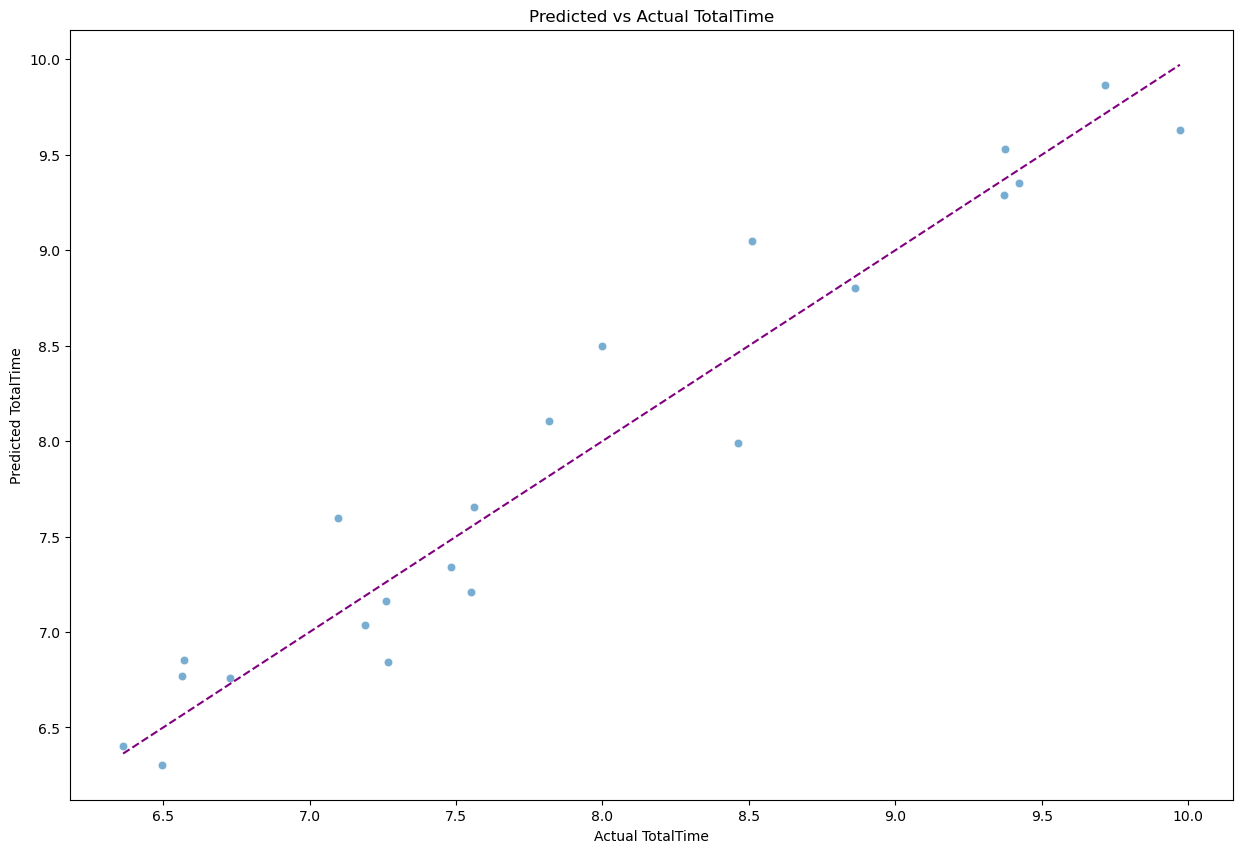

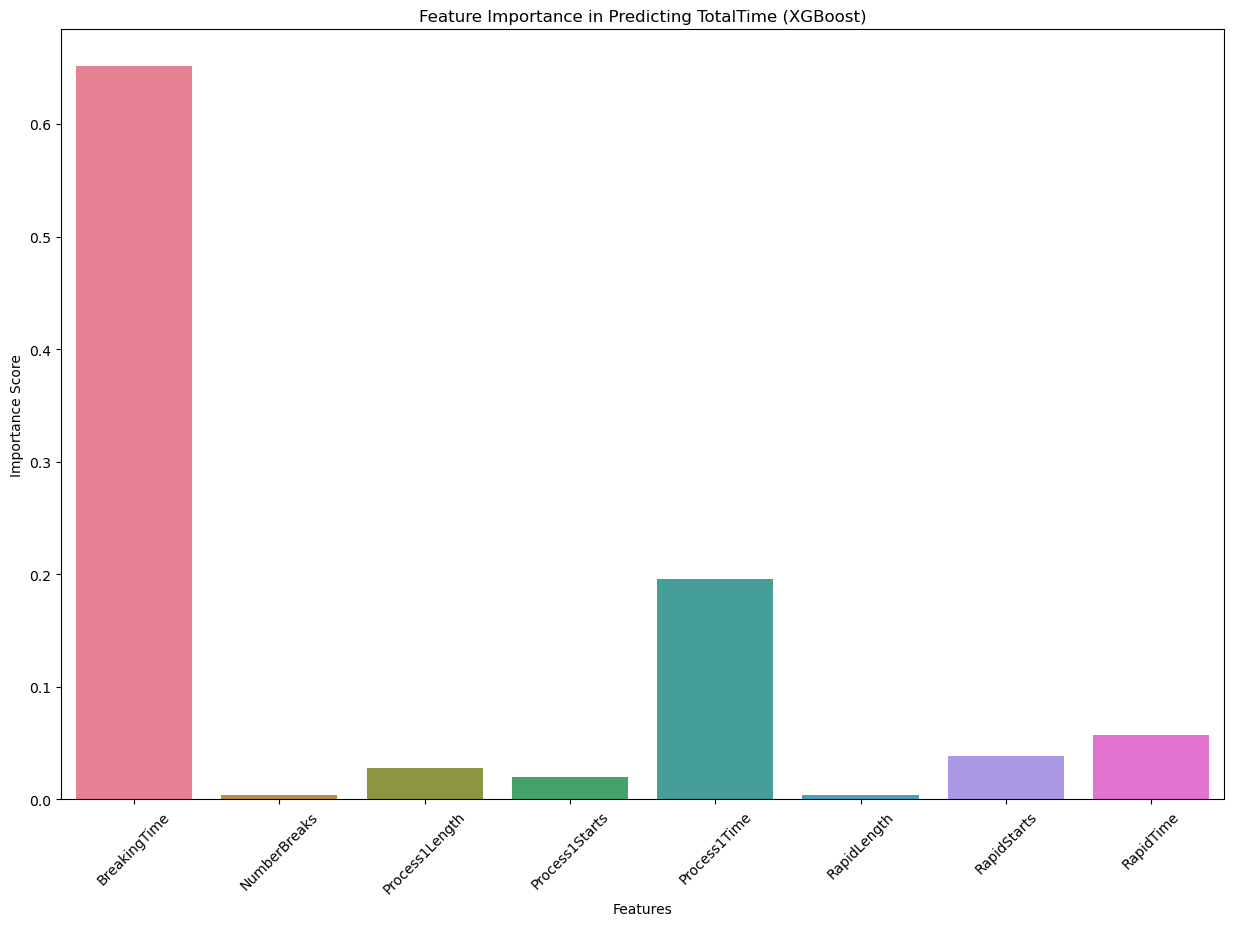

In [52]:
perform_xgboost_regression(df_full_plates_log, target_column)

- The XGBoost model identified BreakingTime as the strongest factor impacting TotalTime. This suggests that delays in removing finished parts from the machine bed contribute significantly to the overall job duration.

- Process1Time remains a key determinant of TotalTime. Fine-tuning cutting speeds and torch settings should still be a priority.

- All other features have small effect on predicting TotalTime, less than 20% combined feature importance.

- The difference in results may originate from how linear regression assumes linear relationship between variables but XGBoost captures nonlinear interactions. XGBoost assigns a much higher importance to BreakingTime. Perhaps due to its ability to model complex effects that a linear model cannot capture.

### Temporal Analysis

We use time-based analysis to spot trends in plate-cutting efficiency.  Focus on metrics like TotalTime and RapidTime helps us see where we can improve.

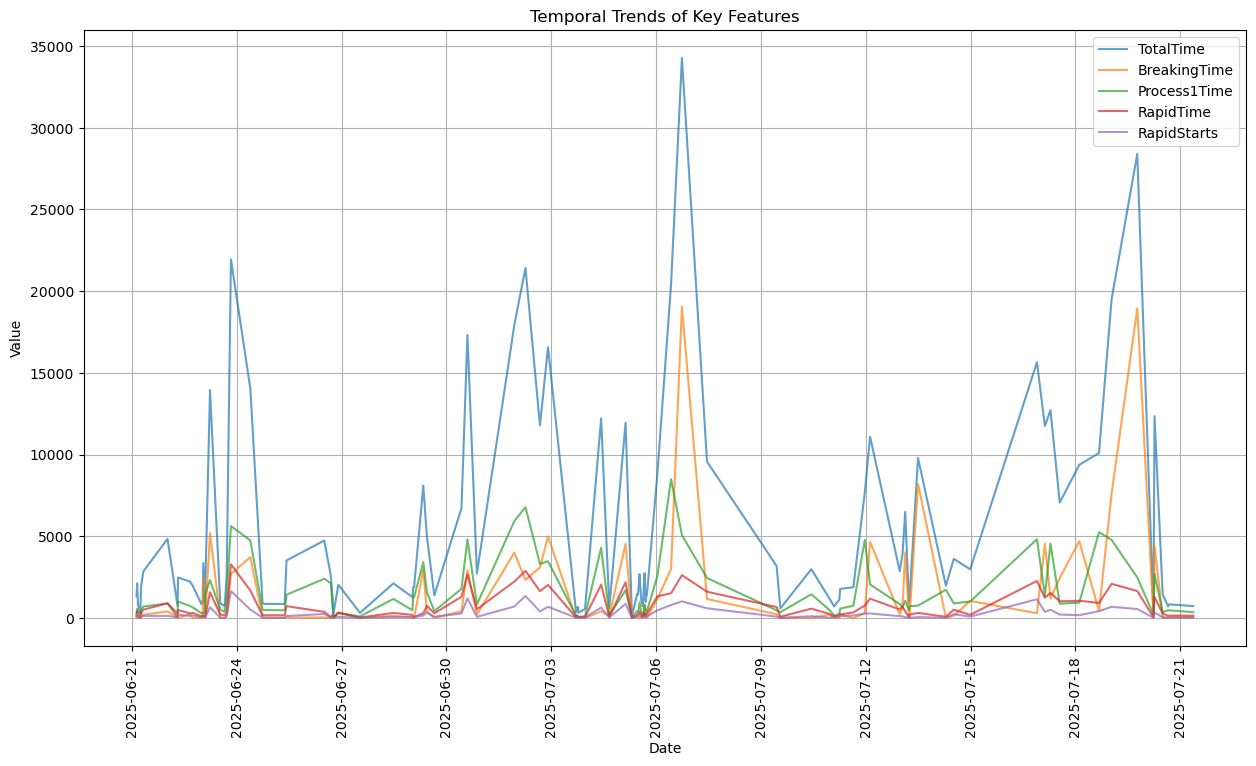

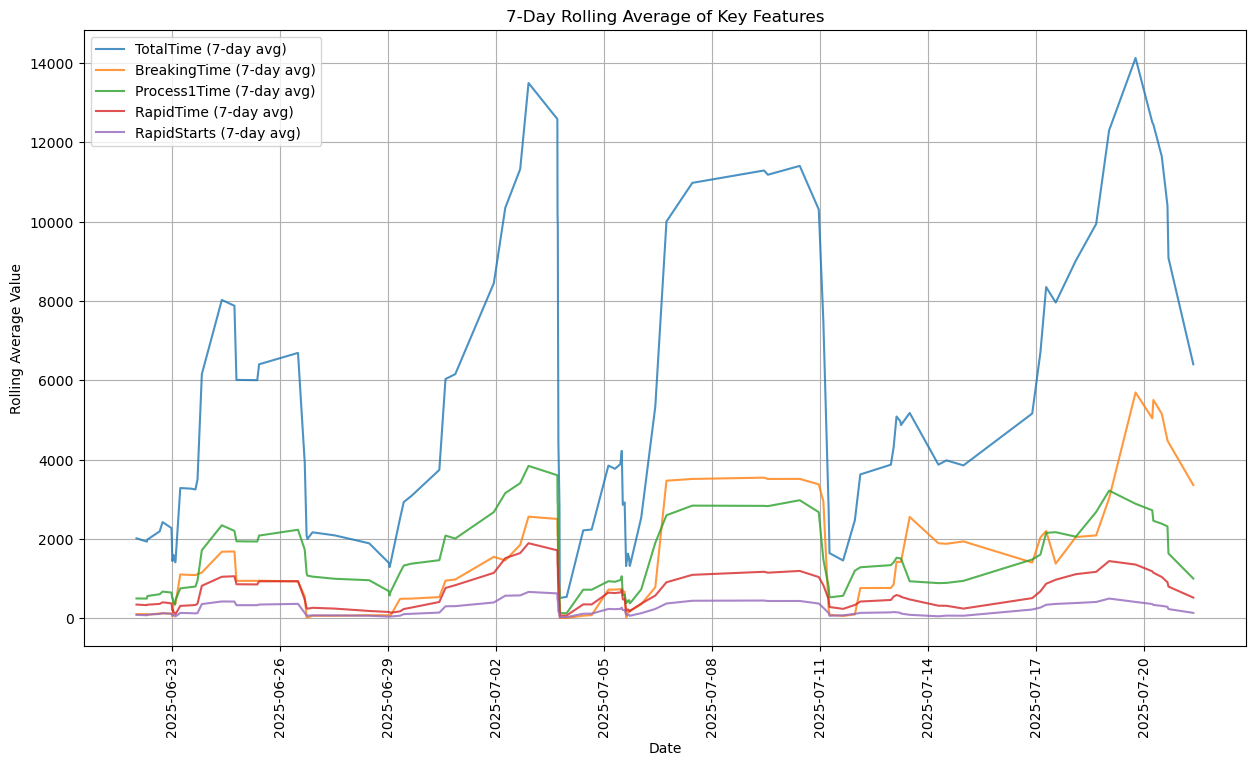

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates


def plot_temporal_trends(df, datetime_col, columns, figsize=(15, 8)):
    df_sorted = df.sort_values(by=datetime_col)
    
    plt.figure(figsize=figsize)
    for col in columns:
        plt.plot(df_sorted[datetime_col], df_sorted[col], label=col, alpha=0.7)
    
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("Temporal Trends of Key Features")
    plt.legend()
    plt.xticks(rotation=90)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Show every 3rd day
    plt.grid(True)
    plt.show()


def plot_rolling_average(df, datetime_col, columns, window=7, figsize=(15, 8)):
    df_sorted = df.sort_values(by=datetime_col)
    
    plt.figure(figsize=figsize)
    for col in columns:
        plt.plot(df_sorted[datetime_col], df_sorted[col].rolling(window=window).mean(), label=f"{col} ({window}-day avg)", alpha=0.8)
    
    plt.xlabel("Date")
    plt.ylabel("Rolling Average Value")
    plt.title(f"{window}-Day Rolling Average of Key Features")
    plt.legend()
    plt.xticks(rotation=90)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.grid(True)
    plt.show()


temporal_columns = ['TotalTime', 'BreakingTime', 'Process1Time', 'RapidTime', 'RapidStarts']
datetime_column = 'Start'


plot_temporal_trends(df_full_plates, datetime_column, temporal_columns)


plot_rolling_average(df_full_plates, datetime_column, temporal_columns, window=7)


- From the rolling averages, both BreakingTime and TotalTime appear to be increasing over time, however, there are statistical tests avaialble to us that will allow us to confirm this observation.

- To confirm we apply autocorrelation (ACF/PACF) tests to check if past values influence future values.

- Trend decomposition separates long-term trends, seasonal patterns, and random noise to identify consistent patterns.

- Importantly for us, regression on time tests whether BreakingTime and TotalTime show statistically significant upward trends.

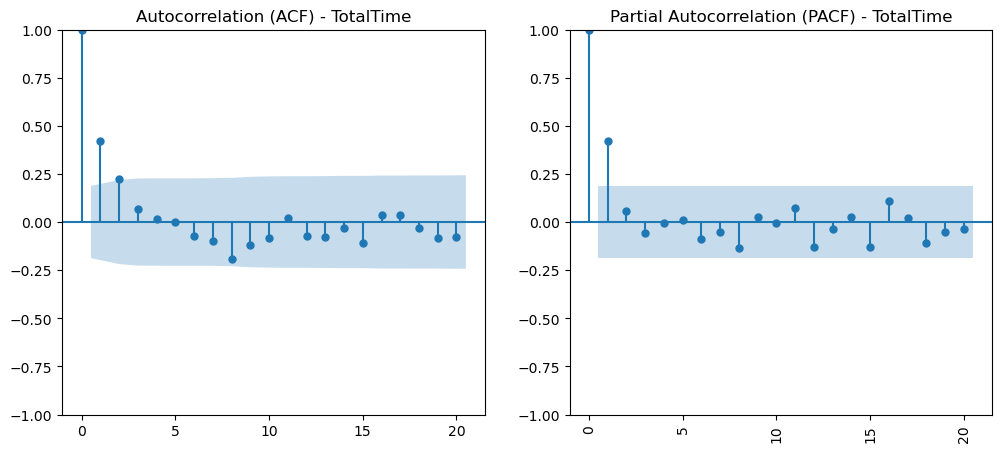

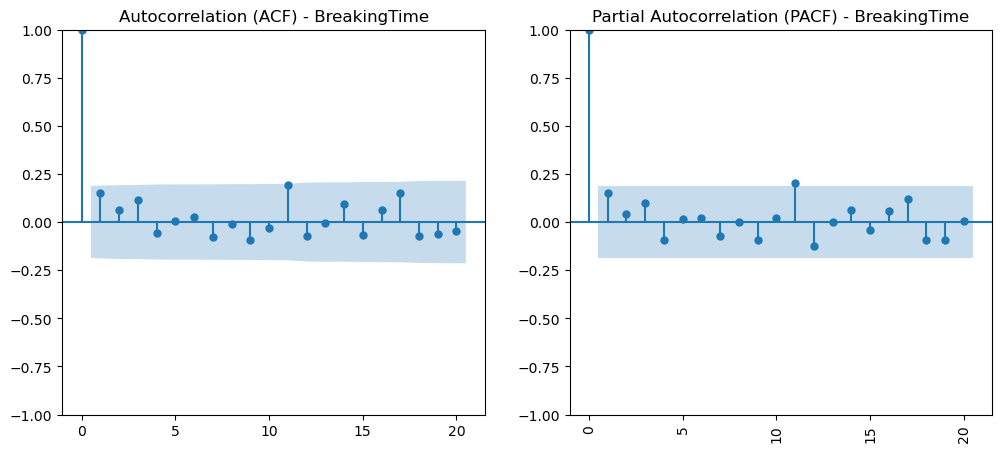

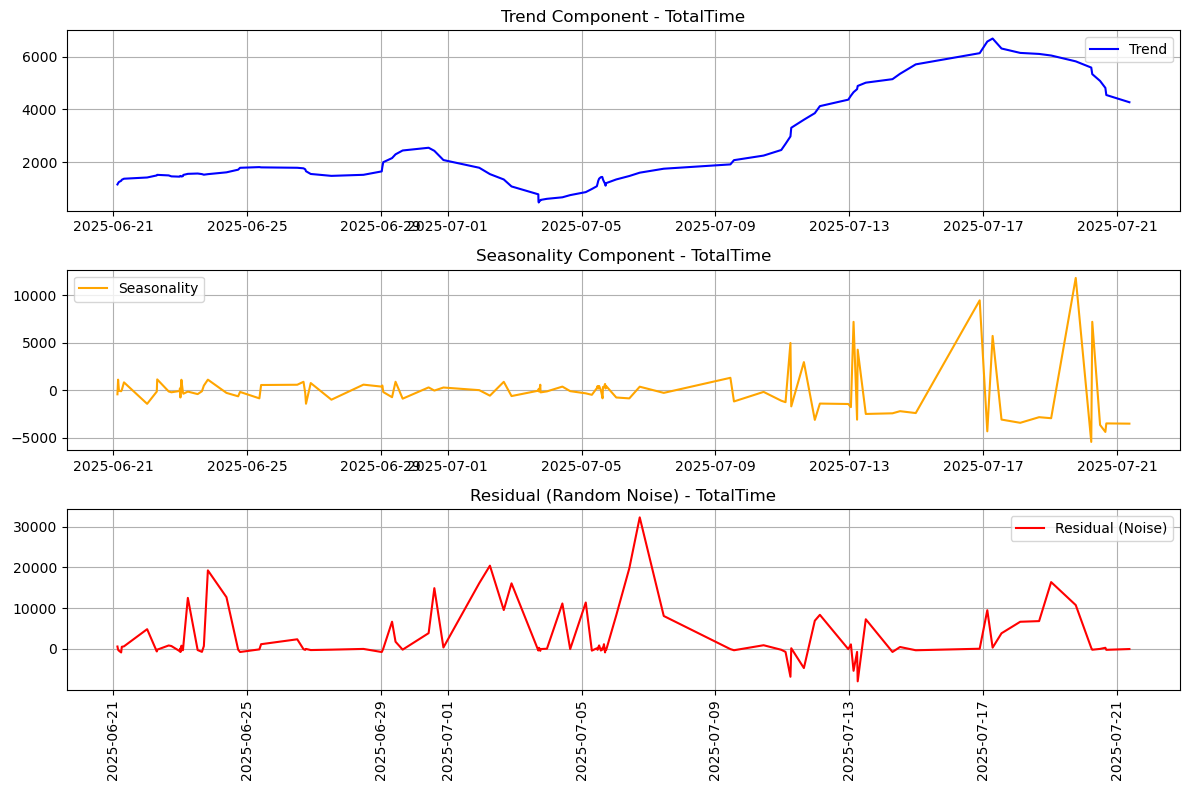

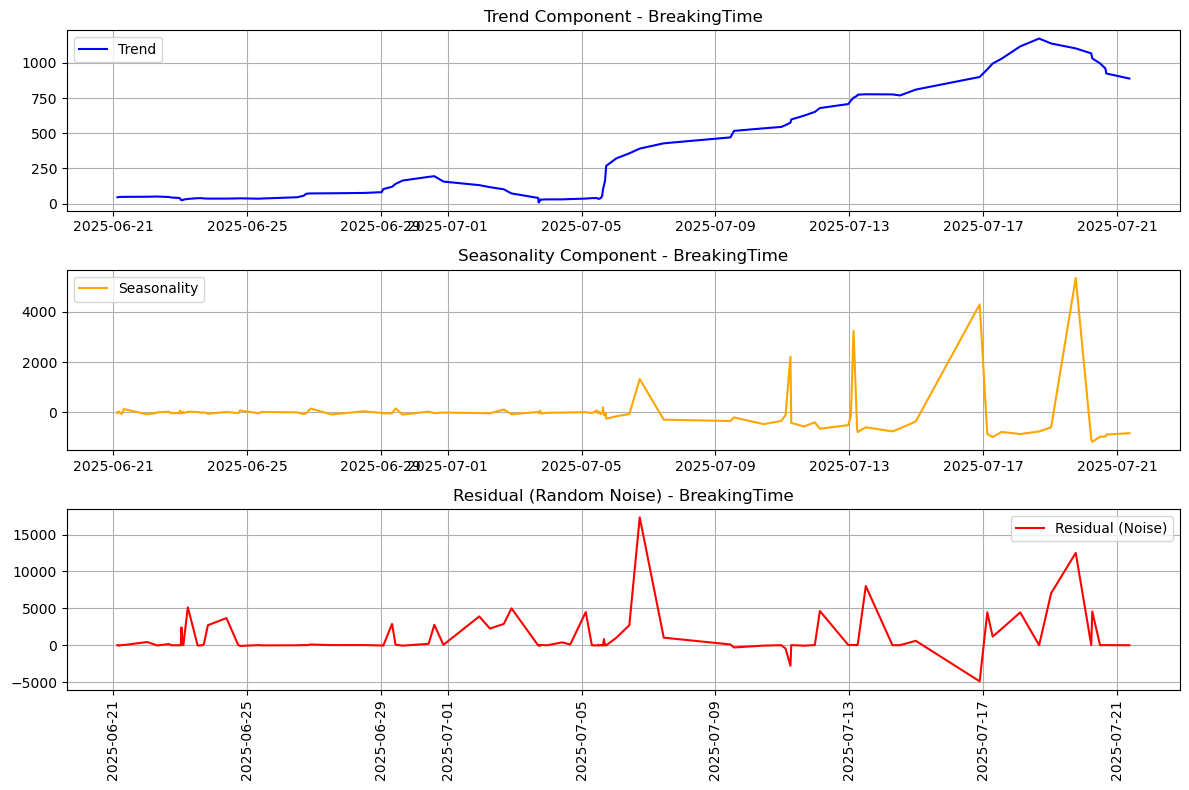

Shannon Entropy for TotalTime: 1.2247
Shannon Entropy for BreakingTime: 0.7513


In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from scipy.stats import entropy

# Select key movement columns - this comes from observation above + results of feature importance
movement_columns = ['TotalTime', 'BreakingTime']
datetime_column = 'Start'


df_sorted = df_full_plates.sort_values(by=datetime_column).copy() # need to sort by datetime for time series analysis
df_sorted.set_index(datetime_column, inplace=True)

# Autocorrelation & Partial Autocorrelation Analysis
def plot_acf_pacf(df, column, lags=20, figsize=(12, 5)):

    fig, ax = plt.subplots(1, 2, figsize=figsize)

    plot_acf(df[column], lags=lags, ax=ax[0])
    plot_pacf(df[column], lags=lags, ax=ax[1])

    ax[0].set_title(f"Autocorrelation (ACF) - {column}")
    ax[1].set_title(f"Partial Autocorrelation (PACF) - {column}")

    plt.xticks(rotation=90)
    plt.show()

# Execute ACF & PACF for movement columns
for col in movement_columns:
    plot_acf_pacf(df_sorted, col)

# Seasonal Trend Decomposition
def decompose_seasonality(df, column, period=7):
    
    stl = STL(df[column], period=period, robust=True)
    result = stl.fit()
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    axes[0].plot(result.trend, label="Trend", color="blue")
    axes[1].plot(result.seasonal, label="Seasonality", color="orange")
    axes[2].plot(result.resid, label="Residual (Noise)", color="red")
    
    axes[0].set_title(f"Trend Component - {column}")
    axes[1].set_title(f"Seasonality Component - {column}")
    axes[2].set_title(f"Residual (Random Noise) - {column}")
    
    
    for ax in axes:
        ax.legend()
        ax.grid(True)

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


# Execute STL decomposition for movement columns
for col in movement_columns:
    decompose_seasonality(df_sorted, col)


# Shannon Entropy Calculation, this measures the uncertainty in a distribution, aka randmoness
def calculate_entropy(df, column, bins=10):
    hist, _ = np.histogram(df[column].dropna(), bins=bins, density=True)
    ent = entropy(hist)
    print(f"Shannon Entropy for {column}: {ent:.4f}")


# Compute entropy for movement columns
for col in movement_columns:
    calculate_entropy(df_sorted, col)


- TotalTime and BreakingTime both show a clear upward trend, confirming the initial visual observation from rolling averages.

- The seasonal component appears to have periodic fluctuations, though weaker than the trend effect.

- A lower entropy for BreakingTime suggests it is more predictable compared to TotalTime, which has higher randomness in its fluctuations.

### Hypothesis Testing

The purpose of this section is to develop multiple hypotheses about the data to create a framework for increasing efficiency. Each hypothesis will be tested, and regardless of whether it is confirmed or rejected, the results will help guide our final recommendations.